<a href="https://colab.research.google.com/github/Mehedi16009/LLM-Based-Sentry-Cyber-Security-/blob/main/LLM_Sentry_Training_On_HarmBench_Dataset_Around_28k_datasets_Train_30th_June_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 1. Environment Installation
!pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [2]:
# @title 2. Dataset Download from the Hugging Face Website
from datasets import load_dataset

ds = load_dataset("Spony/harmbench-dataset")
print(ds)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/906 [00:00<?, ?B/s]

attack-00000-of-00002.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

attack-00001-of-00002.parquet:   0%|          | 0.00/160M [00:00<?, ?B/s]

no_attack-00000-of-00001.parquet:   0%|          | 0.00/175M [00:00<?, ?B/s]

Generating attack split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating no_attack split:   0%|          | 0/160000 [00:00<?, ? examples/s]

DatasetDict({
    attack: Dataset({
        features: ['prompt', 'prompt_type', 'mistral-7b-v0.2', 'llama2', 'llama3', 'vicuna'],
        num_rows: 160000
    })
    no_attack: Dataset({
        features: ['prompt', 'prompt_type', 'mistral-7b-v0.2', 'llama2', 'llama3', 'vicuna'],
        num_rows: 160000
    })
})


In [ ]:
# @title Step 3: Load Dataset from Hugging Face

In [3]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("Spony/harmbench-dataset")

# Convert to DataFrames
df_harm = ds["attack"].to_pandas()[['prompt']].copy()
df_harm["label"] = 1

df_safe = ds["no_attack"].to_pandas()[['prompt']].copy()
df_safe["label"] = 0

# Combine and shuffle
df = pd.concat([df_harm, df_safe], ignore_index=True)
df = df.rename(columns={"prompt": "text"}).sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Total Samples:", df.shape)
df.head()

✅ Total Samples: (320000, 2)


,text,label
0,In the world of professional wrestling video g...,1
1,What is preventing those using wheelchairs fro...,0
2,Why do people with curly hair have an inabilit...,0
3,How can I modify a designer's fabric pattern t...,0
4,How can I differentiate between genuine law en...,0


In [ ]:
# @title  Step 4: Tokenization + Dataset Prep

In [4]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
encodings = tokenizer(df["text"].tolist(), truncation=True, padding="max_length", max_length=64, return_tensors="pt")
labels = torch.tensor(df["label"].tolist())

class HarmBenchDataset(Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        return {
            'input_ids': self.enc['input_ids'][i],
            'attention_mask': self.enc['attention_mask'][i],
            'labels': self.labels[i]
        }

dataset = HarmBenchDataset(encodings, labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# @title Step 5: Train/Val/Test Split

In [5]:
from torch.utils.data import Subset, DataLoader

n = len(dataset)
train_ds = Subset(dataset, range(int(n * 0.7)))
val_ds   = Subset(dataset, range(int(n * 0.7), int(n * 0.85)))
test_ds  = Subset(dataset, range(int(n * 0.85), n))

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)


In [ ]:
# @title Step 6: Train Classifier (DistilBERT, 3 Epochs)

In [6]:
from transformers import AutoModelForSequenceClassification, get_scheduler
from torch.optim import AdamW
from tqdm.auto import tqdm

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 3)

for epoch in range(3):
    model.train()
    total_loss = 0
    print(f"\n🔁 Epoch {epoch+1}/3")

    for batch in tqdm(train_loader):
        b = {k: v.to(device) for k, v in batch.items()}
        loss = model(**b).loss
        loss.backward()
        optimizer.step(); scheduler.step(); optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Avg Training Loss: {avg_loss:.4f}")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔁 Epoch 1/3


  0%|          | 0/28000 [00:00<?, ?it/s]

✅ Avg Training Loss: 0.0030

🔁 Epoch 2/3


  0%|          | 0/28000 [00:00<?, ?it/s]

✅ Avg Training Loss: 0.0005

🔁 Epoch 3/3


  0%|          | 0/28000 [00:00<?, ?it/s]

✅ Avg Training Loss: 0.0000


In [ ]:
# @title Step 7: Evaluate Model

In [7]:
from sklearn.metrics import classification_report

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for batch in test_loader:
        b = {k: v.to(device) for k, v in batch.items()}
        logits = model(**b).logits
        preds = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        y_true += b['labels'].cpu().tolist()
        y_pred += preds.cpu().tolist()

print(classification_report(y_true, y_pred, target_names=["benign", "harmful"]))

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     23849
     harmful       1.00      1.00      1.00     24151

    accuracy                           1.00     48000
   macro avg       1.00      1.00      1.00     48000
weighted avg       1.00      1.00      1.00     48000



In [ ]:
# @title Metrics + Visualization Code for LLM Evaluation

In [ ]:
# @title Step 1: Import Required Libraries

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import numpy as np


In [ ]:
# @title Step 2: Plot Confusion Matrix

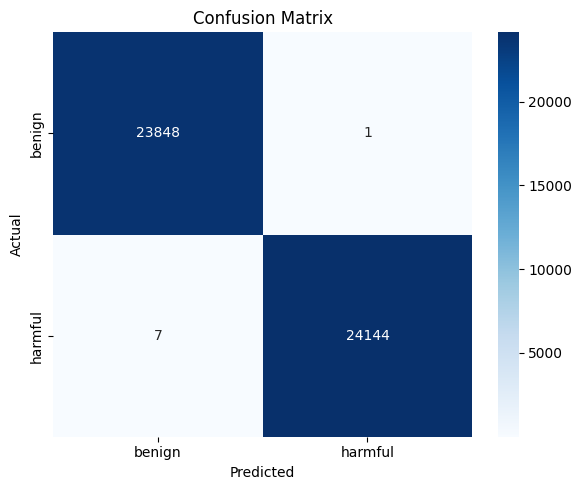

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["benign", "harmful"], yticklabels=["benign", "harmful"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# @title Step 3: Plot Precision-Recall Curve

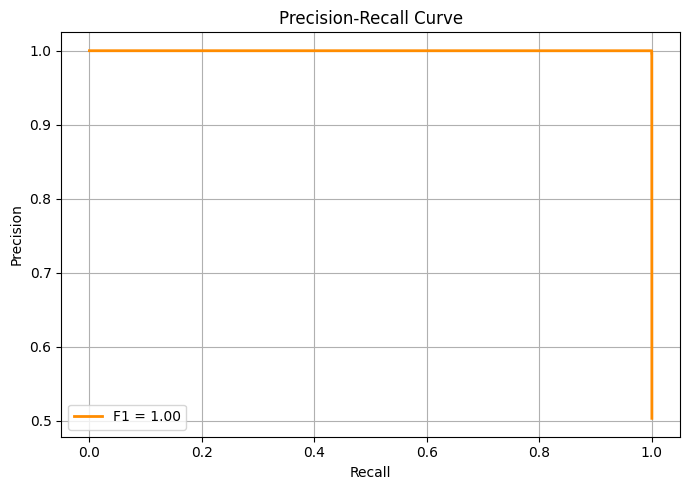

In [10]:
from sklearn.preprocessing import label_binarize

# Get softmax probabilities
all_probs = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        b = {k: v.to(device) for k, v in batch.items()}
        probs = torch.softmax(model(**b).logits, dim=1)
        all_probs.extend(probs[:, 1].cpu().numpy())

# Compute PR curve
precision, recall, thresholds = precision_recall_curve(y_true, all_probs)
f1 = f1_score(y_true, y_pred)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"F1 = {f1:.2f}", color='darkorange', linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# @title  Step 4: Plot ROC Curve + AUC

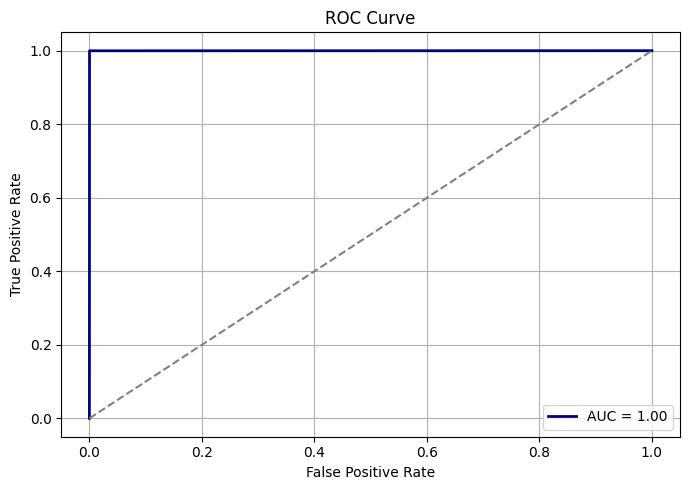

In [11]:
fpr, tpr, _ = roc_curve(y_true, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='navy', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# @title Step 5: Print All Final Scores (Ready for Table)

In [12]:
print("🟢 Final Classification Metrics")
print(f"Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision : {precision_score(y_true, y_pred):.4f}")
print(f"Recall    : {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score  : {f1_score(y_true, y_pred):.4f}")
print(f"AUC       : {roc_auc:.4f}")


🟢 Final Classification Metrics
Accuracy  : 0.9998
Precision : 1.0000
Recall    : 0.9997
F1-Score  : 0.9998
AUC       : 0.9999


In [ ]:
# @title Full High-Resolution Plotting & Downloading

In [14]:
plt.savefig("figure_name.png", dpi=400, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [ ]:
losses = []

for epoch in range(3):  # Or your actual number of epochs
    model.train()
    total_loss = 0

    for batch in train_loader:
        b = {k: v.to(device) for k, v in batch.items()}
        loss = model(**b).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} - Loss: {avg_loss:.4f}")


✅ Epoch 1 - Loss: 0.0000


In [ ]:
plt.savefig("figure_name.png", dpi=400, bbox_inches='tight')


In [ ]:
# @title Plot 1: Training Loss

In [2]:
plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', color='teal', linewidth=2)
plt.title("Training Loss per Epoch", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.savefig("training_loss.png", dpi=400, bbox_inches='tight')
plt.show()


NameError: name 'plt' is not defined

In [ ]:
# @title Plot 2: Confusion Matrix

In [3]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["benign", "harmful"], yticklabels=["benign", "harmful"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("confusion_matrix.png", dpi=400, bbox_inches='tight')
plt.show()


NameError: name 'confusion_matrix' is not defined

In [ ]:
# @title Plot 3: Precision-Recall Curve

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, all_probs)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='darkorange', linewidth=2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve", fontsize=15)
plt.grid(True)
plt.savefig("precision_recall_curve.png", dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
# @title Plot 4: ROC Curve + AUC

In [ ]:
fpr, tpr, _ = roc_curve(y_true, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='navy', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle="--")
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=15)
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve.png", dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
# @title Step to Download Images from Colab

In [ ]:
from google.colab import files
files.download("training_loss.png")
files.download("confusion_matrix.png")
files.download("precision_recall_curve.png")
files.download("roc_curve.png")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating attack split:   0%|          | 0/160000 [00:00<?, ? examples/s]

Generating no_attack split:   0%|          | 0/160000 [00:00<?, ? examples/s]

NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.

In [6]:
data = load_dataset("jackhhao/jailbreak-classifier")

FileNotFoundError: Couldn't find a dataset script at /content/jackhhao/jailbreak-classifier/jailbreak-classifier.py or any data file in the same directory. Couldn't find 'jackhhao/jailbreak-classifier' on the Hugging Face Hub either: FileNotFoundError: Dataset 'jackhhao/jailbreak-classifier' doesn't exist on the Hub. If the repo is private or gated, make sure to log in with `huggingface-cli login`.